In [11]:
import pandas as pd
import pickle
import numpy as np
data = pickle.load(open('../data/leftppgecg.p','rb'))

In [12]:
data_filtered = data.dropna()

In [13]:
import warnings
warnings.filterwarnings('ignore')
data_filtered['red_rr'] = data['ppg_rr'].apply(lambda x:x[0])
data_filtered['ir_rr'] = data['ppg_rr'].apply(lambda x:x[1])
data_filtered['green_rr'] = data['ppg_rr'].apply(lambda x:x[2])
data_filtered['red_qual'] = data['likelihood'].apply(lambda x:x[0])
data_filtered['ir_qual'] = data['likelihood'].apply(lambda x:x[1])
data_filtered['green_qual'] = data['likelihood'].apply(lambda x:x[2])

In [19]:
columns = ['red','ir','green']
X = []
for c in columns:
    temp = data_filtered[[c+'_rr',c+'_qual','ecg_rr']].values
    X.append(temp)
X = np.concatenate(X,axis=0)

In [20]:
X = X[X[:,0]>0]

In [21]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


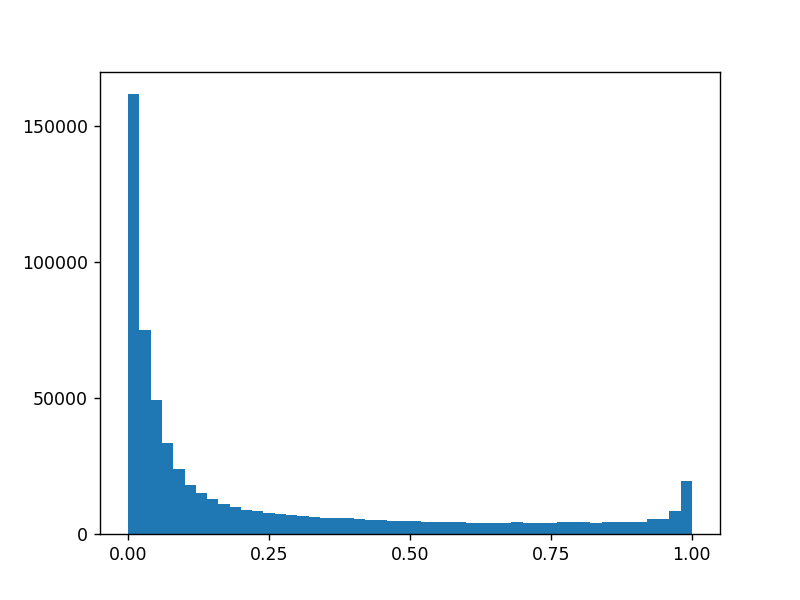

In [22]:

plt.figure()
plt.hist(X[:,1],50)
plt.show()
# X

In [23]:
l_range = np.arange(0,1,.05)
x = []
y = []
for l in l_range:
    index = np.where((X[:,1]>=l)&(X[:,1]<l+.05))[0]
    temp = X[index]
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,0]-temp[:,2])))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
plt.boxplot(y,showfliers=False)
plt.xticks(range(1,len(x)+1),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

<IPython.core.display.Javascript object>


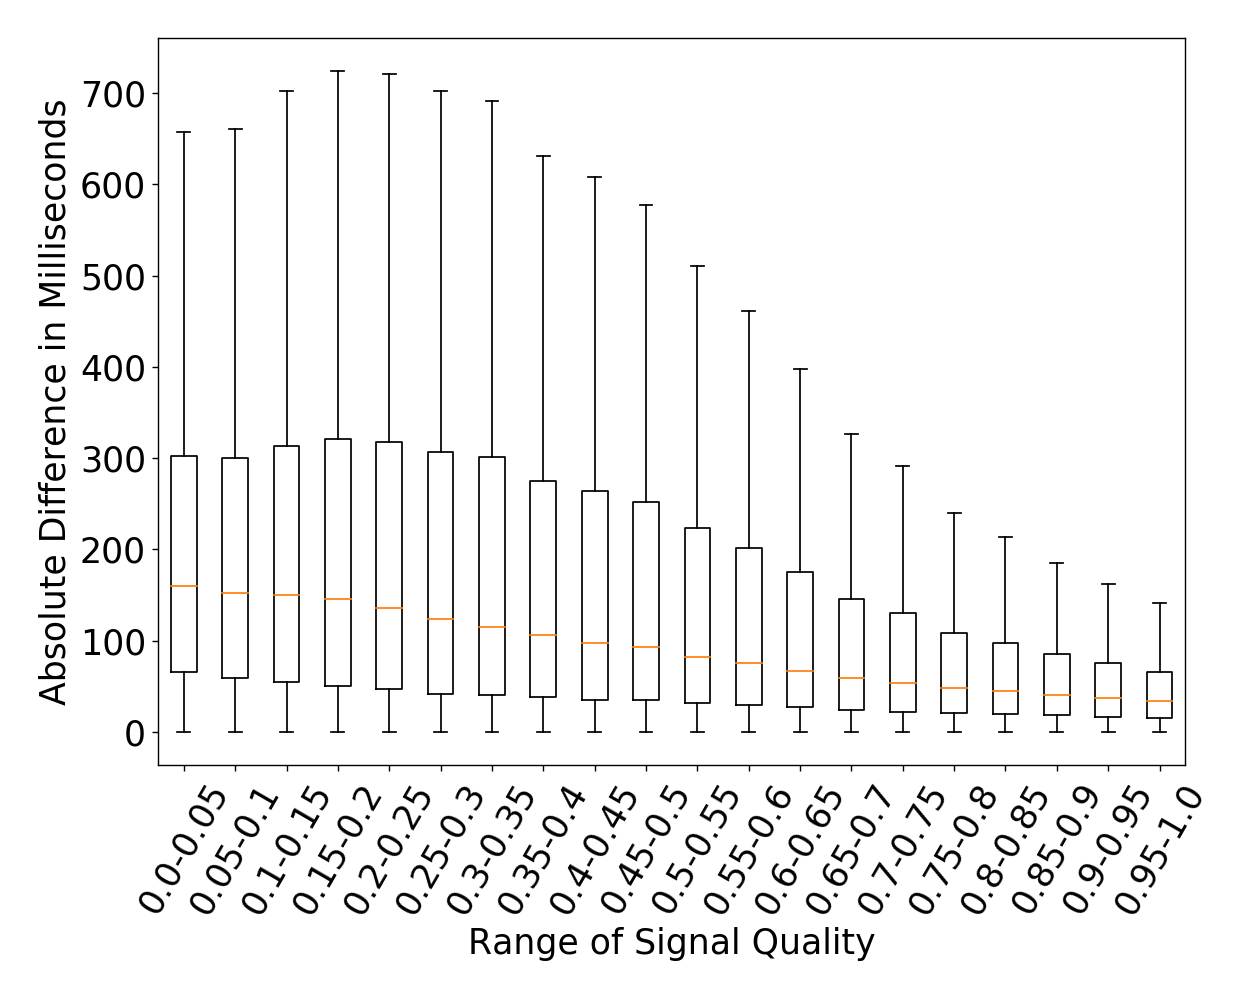

In [25]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed


from copy import deepcopy
data_all = deepcopy(data)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','red_rr','ir_rr','green_rr','ecg_rr']].values
    return df.reshape(-1,60,9)
all_X = []
for user in unique_users:
    data_user = data_all[data_all.user.isin([user])]
    data_user.set_index('timestamp',inplace=True)
    data_resampled = data_user.resample('1S').mean()
    df_col = Parallel(n_jobs=10,verbose=1)(delayed(get_data)(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60)
    all_X.append(np.concatenate(df_col))
        

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 9940 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done 19980 tasks      | elapsed:   13.6s
[Parallel(n_jobs=10)]: Done 20165 out of 20165 | elapsed:   13.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 11180 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done 21760 tasks      | elapsed:   13.5s
[Parallel(n_jobs=10)]: Done 21844 out of 21844 | elapsed:   13.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapse

In [6]:
X = np.concatenate(all_X)

In [10]:
import pickle
pickle.dump(X,open('../data/60_second_data.p','wb'))

In [75]:
data_resampled['activity'].shape

(3230024,)

In [76]:
data_resampled['activity'].dropna().shape

(3230024,)